In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import numpy as np 
from pytomography.io.SPECT import simind
import torch
from network import UNetCustom

In [2]:
def plot_logs(experiment_code_list):
    n_channels_list = [[int(i) for i in exp_code.split('_')[1].split('x')] for exp_code in experiment_code_list]
    save_dir = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/network_ablation_experiments'
    logs_fpath_list = [os.path.join(save_dir, 'logs', f'{exp_code}', 'logs.csv') for exp_code in experiment_code_list]

    loss_list = [pd.read_csv(path)['Loss'].tolist() for path in logs_fpath_list] 
    epoch_list = [np.arange(len(ll)) + 1 for ll in loss_list]
    min_loss_list = [np.min(ll) for ll in loss_list]

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(1)
    
    for i in range(len(loss_list)):
        ax[0].plot(epoch_list[i], loss_list[i], label=n_channels_list[i])
    
    ax[0].legend()
    ax[1].plot(experiment_code_list, min_loss_list, '-o')
    ax[1].set_xticklabels(n_channels_list, rotation=45, ha='right')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('MSELoss')
    ax[1].set_xlabel('Network ablations')
    ax[1].set_ylabel('Minimum MSELoss')
    plt.show()

/tmp/ipykernel_3471/1623158067.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(n_channels_list, rotation=45, ha='right')


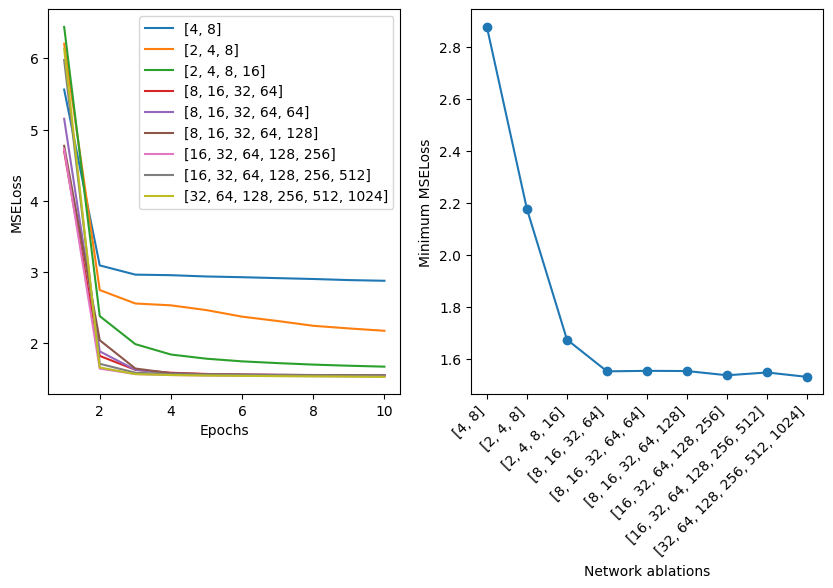

In [3]:
path = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/network_ablation_experiments/models'
experiment_code_list = sorted(os.listdir(path), key=len)
plot_logs(experiment_code_list)

In [4]:
def get_noiseless_and_noisy_scatter_images():
    path = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/simind_tutorial'
    organs = ['bkg', 'liver', 'l_lung', 'r_lung', 'l_kidney', 'r_kidney','salivary', 'bladder']
    activities = [2500, 450, 7, 7, 100, 100, 20, 90] # MBq
    headerfiles = [os.path.join(path, 'multi_projections', organ, 'photopeak.h00') for organ in organs]
    dT = 15 # seconds per projection
    headerfiles_lower = [os.path.join(path, 'multi_projections', organ, 'lowerscatter.h00') for organ in organs]
    headerfiles_upper = [os.path.join(path, 'multi_projections', organ, 'upperscatter.h00') for organ in organs]
    projections = simind.get_projections([headerfiles, headerfiles_lower, headerfiles_upper], weights=activities)
    projections_realization = torch.poisson(projections * dT)
    ww_peak = simind.get_energy_window_width(headerfiles[0])
    ww_lower = simind.get_energy_window_width(headerfiles_lower[0])
    ww_upper = simind.get_energy_window_width(headerfiles_upper[0])
    lower_scatter = projections_realization[1].unsqueeze(0)
    upper_scatter = projections_realization[2].unsqueeze(0)
    scatter = (lower_scatter/ww_lower+upper_scatter/ww_upper)*ww_peak/2
    lower_scatter_noiseless = projections[1].unsqueeze(0) * dT
    upper_scatter_noiseless = projections[2].unsqueeze(0) * dT
    scatter_noiseless = (lower_scatter_noiseless/ww_lower+upper_scatter_noiseless/ww_upper)*ww_peak/2
    return scatter_noiseless, scatter

In [8]:
def plot_images(experiment_code_list, projection_num):
    n_channels_list = [[int(i) for i in exp_code.split('_')[1].split('x')] for exp_code in experiment_code_list]
    save_dir = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/network_ablation_experiments'
    preds_fpath_list = [os.path.join(save_dir, 'predictions', f'{exp_code}', 'pred.pt') for exp_code in experiment_code_list]
    scatter_noiseless, scatter = get_noiseless_and_noisy_scatter_images()
    
    fig, ax = plt.subplots(1, 2+len(experiment_code_list), figsize=(5*(2 + len(experiment_code_list)), 10))
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(1)
    mse_list = []
    ax[0].imshow(np.rot90(scatter_noiseless[0, projection_num].cpu()), cmap='magma', vmax=16)
    ax[1].imshow(np.rot90(scatter[0, projection_num].cpu()), cmap='magma', vmax=16)
    ax[0].set_title('Noiseless scatter', fontsize=16)
    ax[1].set_title('Noisy scatter', fontsize=16)
    for i in range(2, 2+len(experiment_code_list)):
        scatter_pred = torch.load(preds_fpath_list[i-2])
        sq_diff = (scatter_pred - scatter_noiseless)**2
        mse = torch.mean(sq_diff)
        mse_list.append(mse.item())
        ax[i].imshow(np.rot90(scatter_pred[0, projection_num].cpu().detach()), cmap='magma', vmax=16)
        ax[i].set_title(n_channels_list[i-2], fontsize=16)

    for i in range(2+len(experiment_code_list)):
        ax[i].axis('off')
    plt.show()
    return mse_list
    # return scatter_pred_list

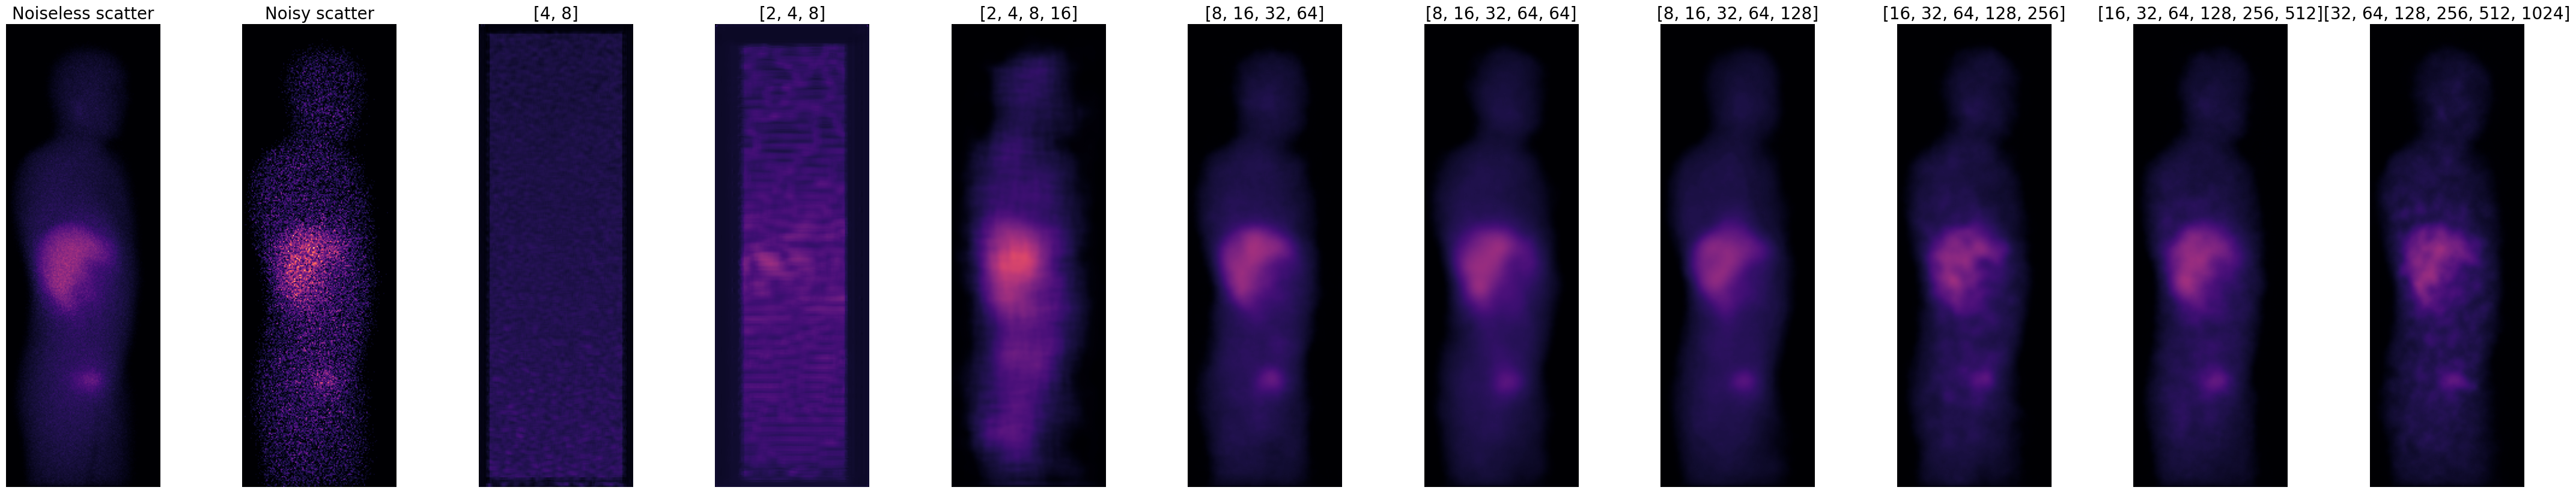

/tmp/ipykernel_3471/3963816466.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(n_channels_list, rotation=45, ha='right')


Text(0.5, 1.0, 'Scatter predicted vs. Scatter noiseless')

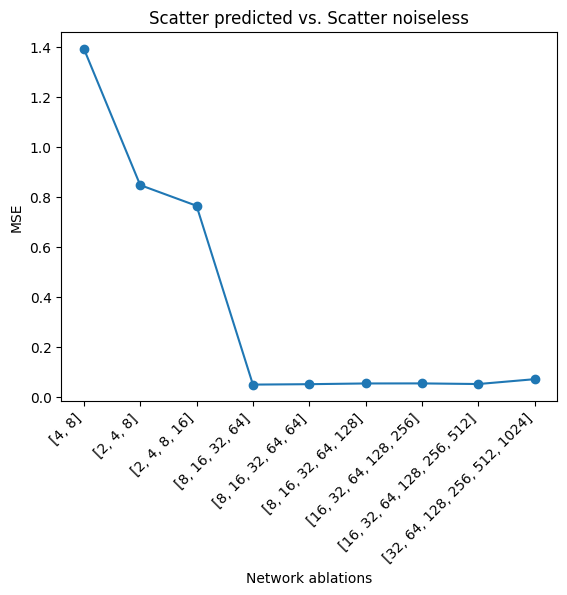

In [9]:
mse_list = plot_images(experiment_code_list, 20)
n_channels_list = [[int(i) for i in exp_code.split('_')[1].split('x')] for exp_code in experiment_code_list]
fig, ax = plt.subplots()
ax.plot(experiment_code_list, mse_list, '-o')
ax.set_xticklabels(n_channels_list, rotation=45, ha='right')
ax.set_xlabel('Network ablations')
ax.set_ylabel('MSE')
ax.set_title('Scatter predicted vs. Scatter noiseless')

/tmp/ipykernel_15965/3793066177.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(n_channels_list, rotation=45, ha='right')


Text(0.5, 1.0, 'Scatter predicted vs. Scatter noiseless')

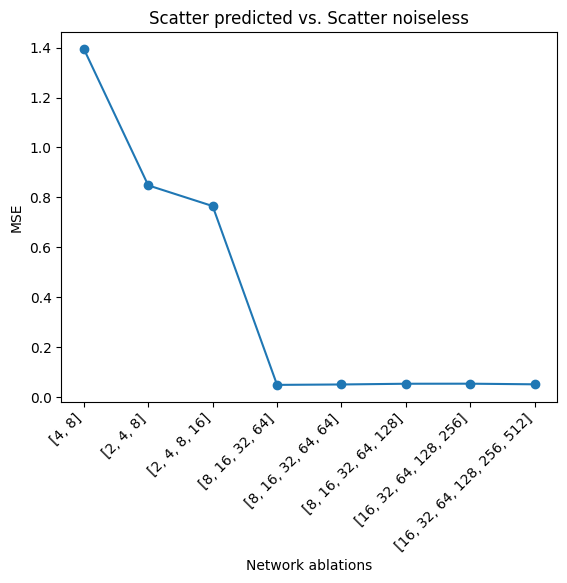

In [22]:
unet = UNetCustom([8,16,32, 64, 128])
mpath = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/network_ablation_experiments/models/unet_8x16x32x64x128/checkpoint=10.pth'
unet.load_state_dict(torch.load(mpath))

<All keys matched successfully>

In [23]:
scatter_pred = unet(input_)
scatter_pred = scatter_pred.swapaxes(1,0)

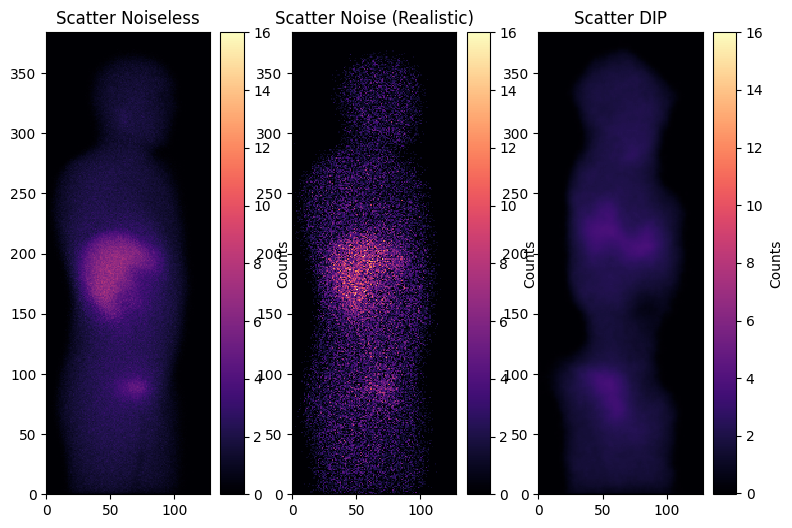

In [24]:
projection_number = 20
plt.subplots(1,3,figsize=(9,6))
plt.subplot(131)
plt.pcolormesh(scatter_noiseless[0,projection_number].cpu().T,  cmap='magma', vmax=16)
# plt.axis('off')
plt.colorbar(label = 'Counts')
plt.title('Scatter Noiseless')
plt.subplot(132)
plt.pcolormesh(scatter[0,projection_number].cpu().T,  cmap='magma', vmax=16)
# plt.axis('off')
plt.colorbar(label = 'Counts')
plt.title('Scatter Noise (Realistic)')
plt.subplot(133)
plt.pcolormesh(scatter_pred[0,projection_number].cpu().detach().T,  cmap='magma', vmax=16)
# plt.axis('off')
plt.colorbar(label = 'Counts')
plt.title('Scatter DIP')
plt.show()